In [1]:
import numpy as np
import psana as ps
import matplotlib.pyplot as plt
import sys
import time
import pickle
import os
from Functions import *
from raw_data_class import RawData as RDC
from processed_data_class import processed_data_class as PDC
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [ ]:
save_dir = '/reg/d/psdm/cxi/cxilv2718/results/data/'
calib_dir = '/reg/d/psdm/cxi/cxilv2718/results/calibrations/'
runs = np.append(44,np.arange(72,75))#np.append(44,np.arange(48,60)) # goes from first value in range to last - 1
epix_roi= [90,140,190,300]
xrt_roi = [400,1100]
calibration_file = 'calibration_2'
# Processing or Loading
process_raw = False
on_off = False # Do you want to plot the raw data?

plot_one = 55
plot_one_idx = np.searchsorted(runs,plot_one)
x_axis = 'pixels' # 'pixels' or 'energy'
to_cal_file = [calib_dir, calibration_file]

In [ ]:
# Energy Calibration, plot raw calibration runs with pixel axis and populate these arrays
save_cal = False
if save_cal is True:
    calib_runs = list(range(33,41))
    notch_energies = [7.04,7.045,7.05,7.055,7.065,7.07,7.075,7.08] # keV
    xrt_pixels =  [1030,946,859,780,607,521,438,0] # enter 0 if you can't see the notch
    epix_pixels = [0,0,215,228,254,266,279,0] # enter 0 if you can't see the notch

    labels = ['notch_energies','xrt_pixels','epix_pixels','rois','to_cal_file','calib_runs']
    rois = [xrt_roi,epix_roi]
    calib_in = [labels, notch_energies,xrt_pixels,epix_pixels,rois,to_cal_file,calib_runs]
    calib_out = energy_calib.energy_calib(calib_in,save_cal)
    print('')
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]
if os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl') and save_cal is False:
    with open(to_cal_file[0] + to_cal_file[1] +'.pkl', "rb") as f:
        calib_out = pickle.load(f)
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]   
    
if not os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl'):
    print(to_cal_file[1] + ' does not exist.')
    print('No calibration file loaded.')

In [ ]:
# Raw Data
plot_one = 75
raw_datas = []
for run in runs:
    scan_name = 'run_' + str(run)
    ds_string = 'exp=cxilv2718:run='+str(run)+':smd'
    print(ds_string)
    if process_raw:
        raw_data = load_data.load_data(save_dir,scan_name,ds_string,epix_roi,xrt_roi)
    else:
        if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
            with open(save_dir + scan_name + "/" + "rawdata.pkl", "rb") as f:
                raw_data = pickle.load(f)
        else:
            print('You are trying to load a file that does not exist.')
    if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
        raw_datas = raw_datas + [raw_data]

[load_data.add_cal_info(raw_datas[i],to_cal_file) for i in range(0,len(raw_datas))]
plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)

# plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)
# plt.figure()
# [plt.plot(raw_datas[i].epix_energy_windowed,np.mean(raw_datas[i].epix_windowed,0),label=raw_datas[i].scan_name) for i in range(0,len(runs))]
# # [plt.plot(raw_datas[i].xrt_energy_windowed,np.mean(raw_datas[i].xrt_windowed,0),label=raw_datas[i].scan_name) for i in range(0,len(runs))]

# plt.legend()
# plt.xlabel('energy,keV')
# # plt.title('XRT Spectra Stacked')
# plt.title('Epix Spectra Stacked')
# plt.show()

In [ ]:
# Applys an energy window to both spectra. Decide on window based on epix spectrum above.
# Also, reduces the resolution of the xrt spectrometer to match that of the epix.
energy_window = [7.04775,7.07725]
for i in range(0,len(raw_datas)):
    reduce_xrt_res.apply_window(raw_datas[i],energy_window)
    reduce_xrt_res.reduce_res(raw_datas[i])


# plt.figure()
# plt.plot(raw_data.epix_energy_windowed,np.sum(raw_data.xrt_red_res,0))
# plt.plot(raw_data.xrt_energy_windowed,np.sum(raw_data.xrt_windowed,0),alpha=0.5)
# plt.show()

In [ ]:
# Inputs for filters
# filters = [filter0,filter1, ...,filterN]

            # filterX[0] = On/Off # True or False
            # filterX[1] = Type # 'bounds','linearity','rms'
            # filterX[2] = [par0,par1,...,parN]
            
                # If Type = 'bounds'    # par0 = 'key_0' # key_X is string from raw_data.getKeys()
                                        # par1 = lower bound # check raw_data.keyX for starting point 
                                        # par2 = upper bound # 'None' if no upper bound
                                        # par3 = number of stds from median allowed
            
                # If Type = 'linearity' # par0 = 'key_0','key_1' # key_0 and key_1 and x and y values, respectively
                                        # par1 = width of filter
                                        # par2 = force fit through origin? # True or False
                    
# filterX[3] = [in_1, in_2]
                # in_1 = On/Off # True or false
                # in_2 = plot_one # The run you want to see plots for. Declared above in the 2nd block.

# print(raw_data.getKeys()) 
suspress_output = False
filt0 = [True,'bounds',['low_diode_us',0.1,'None',3],[False,plot_one]]
filt1 = [True,'bounds',['high_diode_us',0.1,'None',2],[False,plot_one]]
filt2 = [True,'bounds',['photon_energies',0.945,'None',2],[False,plot_one]]
filt3 = [True,'bounds',['pulse_energies_fee',0.3,'None',2],[False,plot_one]]

# The linearity filters create their fit based on data points that make it through
# the bounds filters.

# filt4 = [True,'linearity',['xrt_intensity','epix_intensity',0.08,True],[True,plot_one]]
filt5 = [True,'linearity',['low_diode_us','epix_intensity',0.1,True],[True,plot_one]]
filt6 = [True,'linearity',['low_diode_us','xrt_intensity',0.1,True],[True,plot_one]]

filters = [filt0,filt1,filt2,filt3,filt5,filt6]
# filters = [filt0,filt1,filt2,filt3,filt4,filt5,filt6]

conditions = [Filters.filtering(raw_datas[i],filters,suspress_output) for i in range(0,len(raw_datas))]

In [ ]:
# Make or load processed data
make_pro = True
pro_datas = []
probe_run = [44,make_pro]
scaling = True # True = 'avg(x)/avg(y)'| False =  'avg(x/y)' 

for i in range(0,len(raw_datas)):
    if make_pro:
        if i is np.searchsorted(runs,probe_run[0]):
            new_scale = raw_datas[np.searchsorted(runs,probe_run[0])].make_pro_data(conditions[np.searchsorted(runs,probe_run[0])],filters)
            probe_run = new_scale.scale_spectrometers(probe_run,scaling)
        processed_data = raw_datas[i].make_pro_data(conditions[i],filters)
        pro_datas = pro_datas + [processed_data]
    else:
        if os.path.exists(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl"):
            with open(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl", "rb") as f:
                processed_data = pickle.load(f)
                pro_datas = pro_datas + [processed_data]
                print('Loaded processed_data for run ' + processed_data.scan_name)
        else:
            print('You are trying to load a file that does not exist.')
        
    pro_datas[i].scale_spectrometers(probe_run,scaling)

len(pro_datas)

# probe_run = [26,True]
# probe_run = pro_datas[-1].scale_spectrometers(probe_run)

In [ ]:
# rand_vals = epix[np.random.choice(epix.shape[0], np.int64(epix.shape[0]/2), replace=False)]

plot_one = 48
plot_one_idx = np.searchsorted(runs,plot_one)
epix = pro_datas[plot_one_idx].epix_norm
xrt = pro_datas[plot_one_idx].xrt_based_norm
# xrt_norm = pro_datas[plot_one_idx].xrt_norm

energy = pro_datas[plot_one_idx].epix_energy_windowed
boot = 50
plt.figure()
for i in range(0,boot):
    rand_=[np.random.choice(epix.shape[0], np.int64(epix.shape[0]/2), replace=False)]
    rand_vals_epix = epix[rand_]
    rand_vals_xrt = xrt[rand_]
    rand_residuals = np.subtract(np.mean(rand_vals_xrt,0),np.mean(rand_vals_epix,0))
    rand_DeltaT_T = np.divide(rand_residuals,np.mean(rand_vals_xrt,0))
    
#     rand_vals_xrt_norm = xrt_norm[np.random.choice(xrt.shape[0], np.int64(xrt.shape[0]/2), replace=False)]
#     rand_vals_scale = np.divide(np.mean(xrt_norm,0),np.mean(epix,0))
    
#     plt.plot(energy,rand_vals_scale)
    plt.plot(energy,np.mean(rand_vals_epix,0),'o')
    plt.plot(energy,np.mean(rand_vals_xrt,0))
#     plt.plot(energy,rand_DeltaT_T)

plt.title('Bootstrapped Epix Spectrum | run ' + str(plot_one) + ' | # Bootstraps ' + str(boot))
# plt.title('Bootstrapped XRT Spectrum | run ' + str(plot_one) + ' | # Bootstraps ' + str(boot))
# plt.title('Bootstrapped XRT-Epix  | run ' + str(plot_one) + ' | # Bootstraps ' + str(boot))

plt.xlabel('energy, eV')
plt.show()
# np.int64(len(epix)/2)
rand_residuals.shape

print(np.mean(rand_vals_xrt,0).shape)
print(np.mean(rand_residuals,0).shape)

In [ ]:
# Averaging runs for plotting 
scans_to_average = list(range(48,60))
idx = np.searchsorted(runs,scans_to_average)
if False:
    all_epix_shots = np.asarray([pro_datas[i].epix_norm[j] for i in idx for j in range(0,len(pro_datas[i].epix_norm))])
    all_xrt_shots = np.asarray([pro_datas[i].xrt_based_norm[j] for i in idx for j in range(0,len(pro_datas[i].xrt_based_norm))])
    shot_id = [[pro_datas[i].scan_name,pro_datas[i].eventIDs[j]] for i in idx for j in range(0,len(pro_datas[i].xrt_norm))]
# len(all_xrt_shots[:][:][:])
print(len(all_epix_shots))
print(len(all_xrt_shots))
print(len(shot_id))
energy = pro_datas[0].epix_energy_windowed
average_epix_shots = np.mean(all_epix_shots,0)
average_xrt_shots = np.mean(all_xrt_shots,0)
epix_err = np.std(all_epix_shots,0)/np.sqrt(len(all_epix_shots))
xrt_err = np.std(all_xrt_shots,0)/np.sqrt(len(all_xrt_shots))

plt.figure()
plt.plot(energy,average_epix_shots,label='Epix')
plt.plot(energy,average_xrt_shots,label='XRT',alpha=0.6,linestyle='dashed')
plt.legend()
plt.show()

boot = 60
fraction = 1/50
if type(boot)==int:
    plt.figure()
    for i in range(0,boot):
        rand_=np.random.choice(len(all_epix_shots), np.int64(len(all_epix_shots)*fraction), replace=False)
        plt.plot(energy,np.mean(all_epix_shots[rand_],0))
        plt.plot(energy,np.mean(all_xrt_shots[rand_],0),linestyle='dashed',alpha=0.6)
plt.legend(('Epix','XRT'))
plt.title('Bootstrapped with ' + str(boot) + ' loops | ' + str(fraction)  + ' % of data | '+ str(np.int64(len(all_epix_shots)*fraction)) + ' of '+ str(len(all_epix_shots))+ ' shots')

In [ ]:
plt.figure()
print(runs)
plt.scatter(pro_datas[0].fluo_diode_ds,pro_datas[0].high_diode_us,label='no_sample: run 44')
plt.scatter(pro_datas[2].fluo_diode_ds,pro_datas[2].high_diode_us,label='sample: run 73')
plt.xlabel('fluo_diode')
plt.ylabel()
plt.legend()

In [19]:
ds_string = 'exp=cxilv2718:run=82:smd'
ds = ps.DataSource(ds_string)
low_diode_us_events = []
high_diode_us_events = []
fluo_diode_ds_events = []
other_diode_ds_events = []
shot_number = []
i = 0
for nevents, evt in enumerate(ds.events()):
    print('Currently on shot: ' + str(nevents), end="\r", flush=True)

    wave8 = ps.Detector('CXI-DG3-BMMON')
    wave8_evt = wave8.get(evt)
    condition = wave8_evt is None
    if condition:
        continue
    shot_number.append(i)
    i += 1
    diodes = wave8_evt.peakA()
    low_diode_us_evt = -1.0 * diodes[8] /0.046#* 13.0  # /0.12230 #scale by 50 micron Fe foil transmission at 7 keV
    high_diode_us_evt = (-1.0 * diodes[12])-low_diode_us_evt# - low_diode_us_evt
    fluo_diode_ds_evt = -1.0 * diodes[15]
    other_diode_ds_evt = -1.0 * diodes[11]
    
    low_diode_us_events.append(low_diode_us_evt)
    high_diode_us_events.append(high_diode_us_evt)
    fluo_diode_ds_events.append(fluo_diode_ds_evt)
    other_diode_ds_events.append(other_diode_ds_evt)
    




In [ ]:
plt.figure()
plt.scatter(fluo_diode_ds_events,high_diode_us_events,label='run 80')
plt.figure()
plt.hist(fluo_diode_ds_events)


<IPython.core.display.Javascript object>


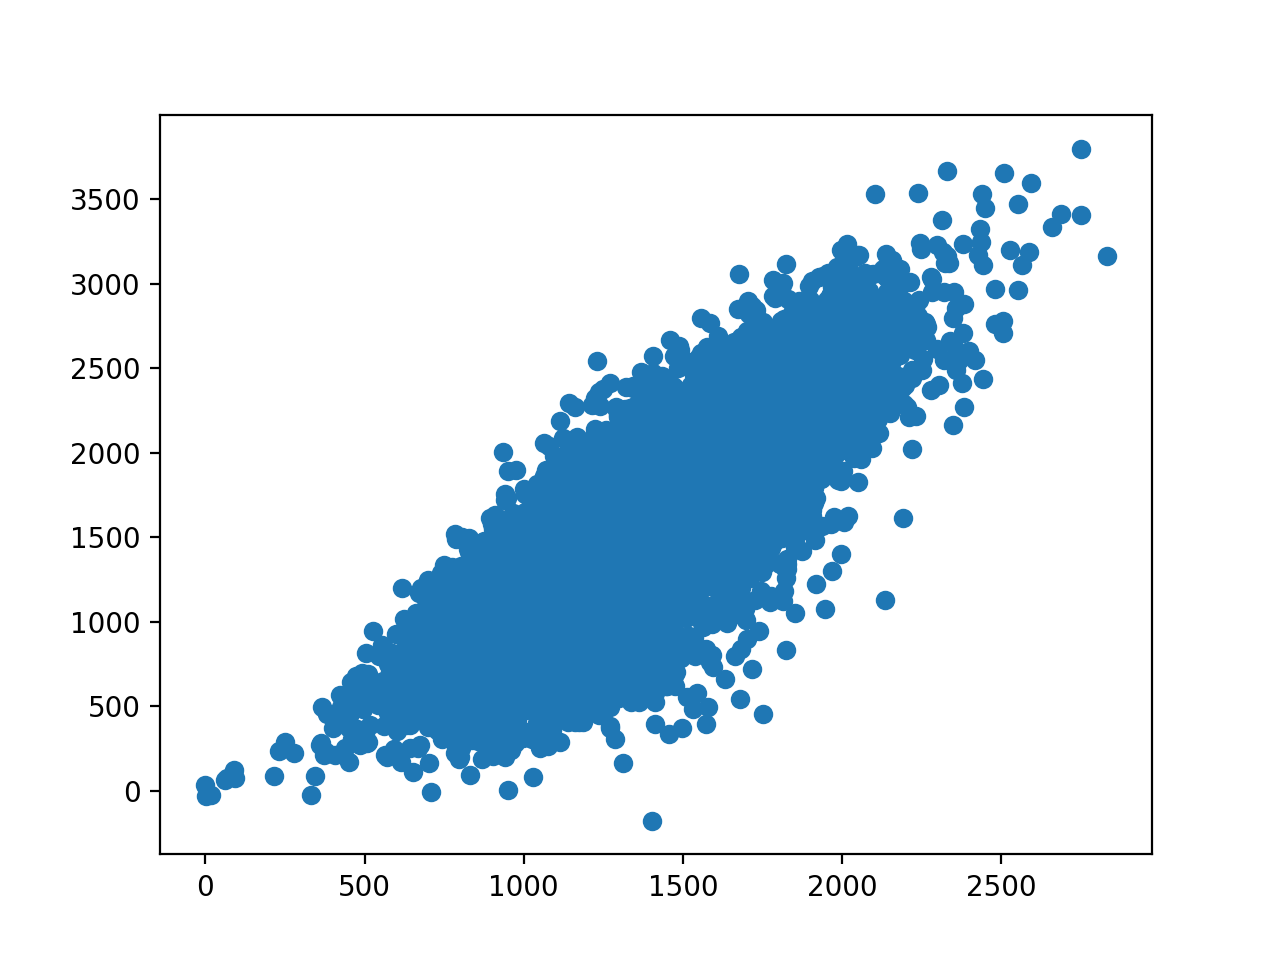

<IPython.core.display.Javascript object>


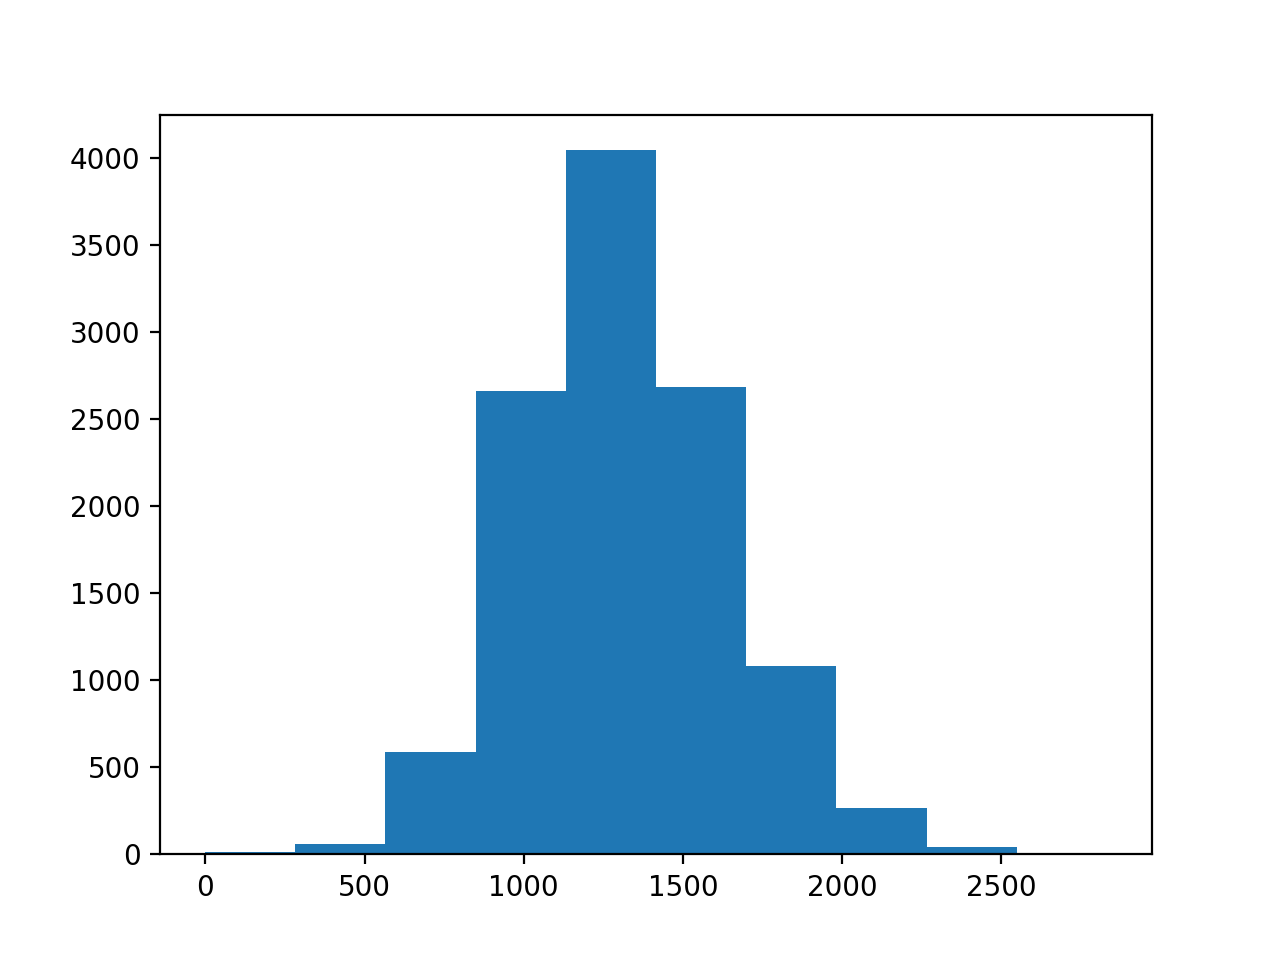

(array([  11.,   57.,  587., 2662., 4043., 2685., 1083.,  264.,   45.,
          10.]),
 array([-7.5000000e-01,  2.8248750e+02,  5.6572500e+02,  8.4896250e+02,
         1.1322000e+03,  1.4154375e+03,  1.6986750e+03,  1.9819125e+03,
         2.2651500e+03,  2.5483875e+03,  2.8316250e+03]),
 <BarContainer object of 10 artists>)

In [15]:
plt.figure()
plt.scatter(fluo_diode_ds_events,high_diode_us_events,label='run 55')
plt.figure()
plt.hist(fluo_diode_ds_events)

<IPython.core.display.Javascript object>


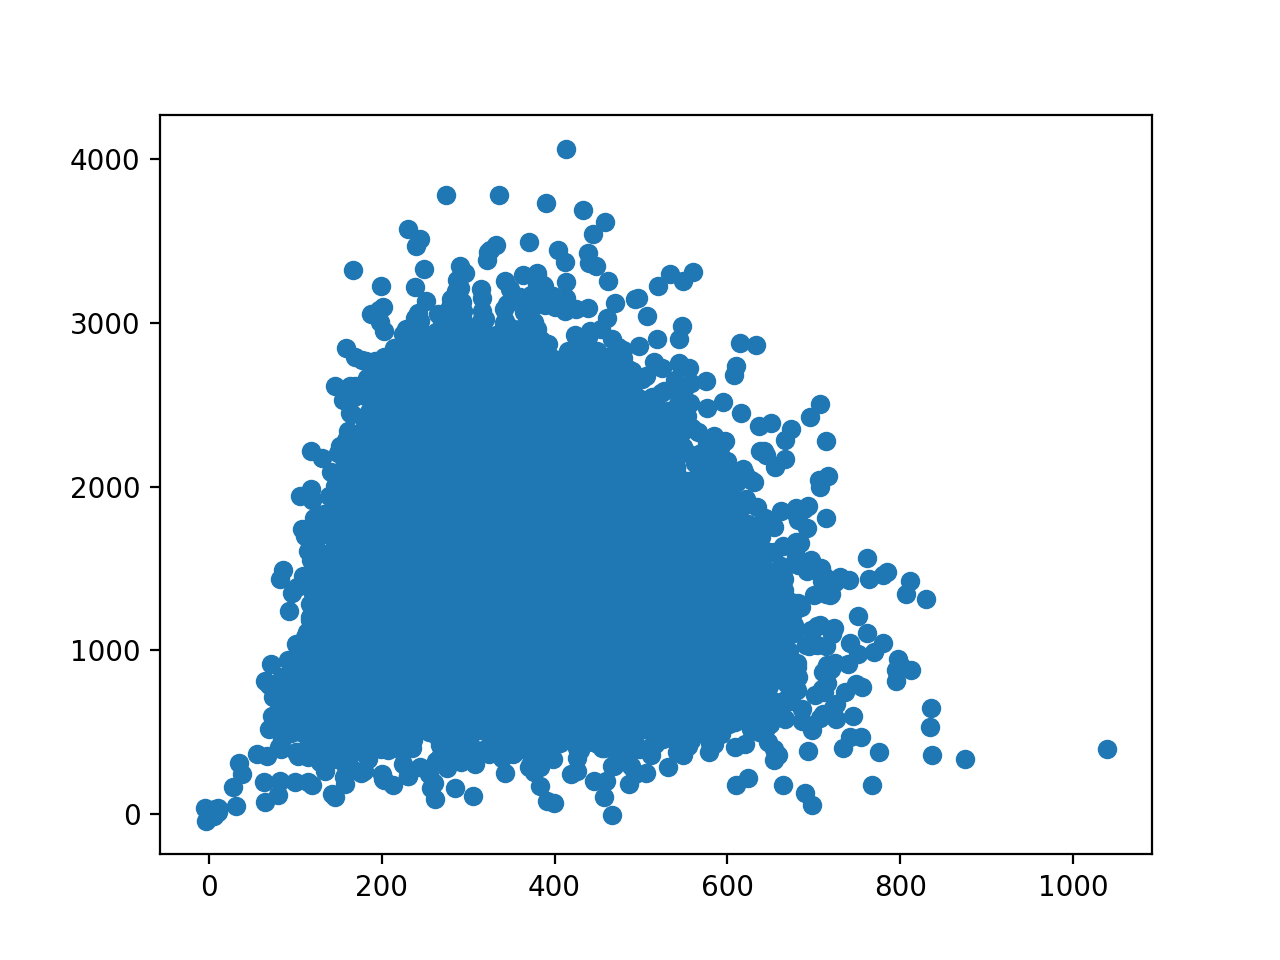

<IPython.core.display.Javascript object>


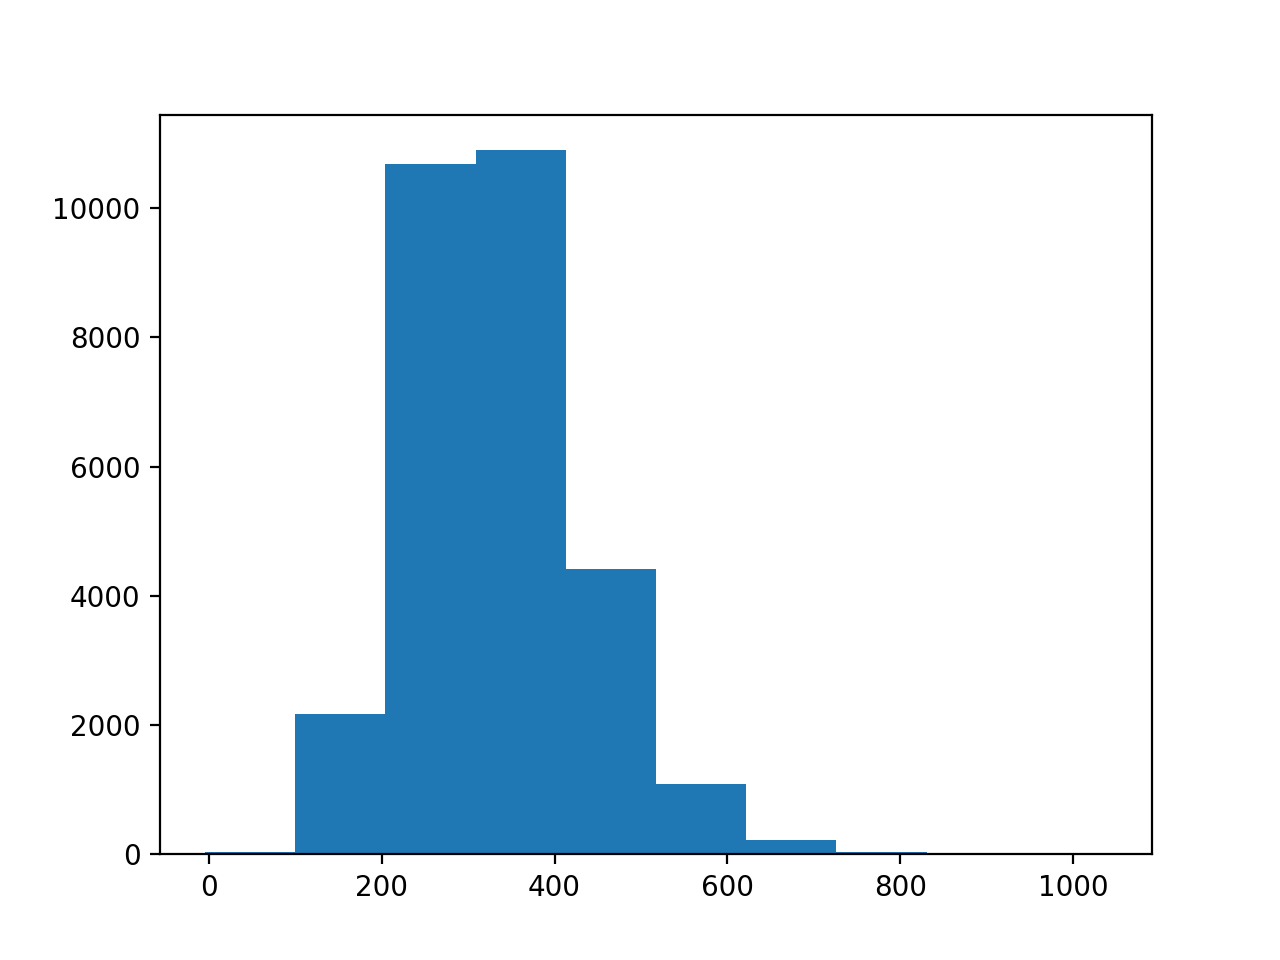

(array([4.2000e+01, 2.1690e+03, 1.0683e+04, 1.0892e+04, 4.4150e+03,
        1.0870e+03, 2.2700e+02, 3.1000e+01, 4.0000e+00, 1.0000e+00]),
 array([  -4.125,  100.175,  204.475,  308.775,  413.075,  517.375,
         621.675,  725.975,  830.275,  934.575, 1038.875]),
 <BarContainer object of 10 artists>)

In [18]:
plt.figure()
plt.scatter(fluo_diode_ds_events,high_diode_us_events,label='run 81')
plt.figure()
plt.hist(fluo_diode_ds_events)